# 1. Regressive Tennis T-Test

Use a linear regression and statsmodels to run a t-test on whether Federer scores more points than his opponents in the `tennis.csv` dataset.

Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value. 

Also answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?

In [ ]:
# ref: http://www.henry.k12.ga.us/ugh/apstat/chapternotes/sec3.3.html
# ref: https://www.youtube.com/watch?v=pcObydOsMXc&ab_channel=ScottStevens

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
sns.set()

In [3]:
tennis = pd.read_csv('data/tennis.csv')
list(tennis)

y = tennis['player1 total points won'].dropna(axis=0)
x = tennis['player2 total points won'].dropna(axis=0)

# x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit(cov_type='HC2')
print(results.summary())

# plt.rc("figure", figsize=(16,8))
# sm.graphics.plot_fit(results, 'player2 total points won', vlines=False)
# plt.show()

                                    OLS Regression Results                                   
Dep. Variable:     player1 total points won   R-squared (uncentered):                   0.969
Model:                                  OLS   Adj. R-squared (uncentered):              0.969
Method:                       Least Squares   F-statistic:                          2.837e+04
Date:                      Wed, 20 Jan 2021   Prob (F-statistic):                        0.00
Time:                              17:04:46   Log-Likelihood:                         -4310.3
No. Observations:                      1027   AIC:                                      8623.
Df Residuals:                          1026   BIC:                                      8628.
Df Model:                                 1                                                  
Covariance Type:                        HC2                                                  
                               coef    std err          z   

**Give a one-paragraph interpretation of the coefficient, and the meaning of the p-value.** 

    The coefficient of 1.1242 indicates that for every 1 point the opponent scores, Federer is likely to score 1.1242. 
    Therefore on overage, for every 8 points an opponent scores, Federer will be in advance by 1 point.
    
    The p-value of 0.000 indicates that the relationship between how many points Federer scores and how many points his opponent score is statistically significant.

**Also answer the following: should your regression include a constant term? Why or why not? How would it change the interpretation of your coefficient and p-value?**

    The R2 value without a constant defines a better fit model (0.969) than one with a constant (0.794), however the fit is better corrected for outliers in a model with a constant.
    The coefficient is lowered in a model with a constant term however the p-value remains 0.000 which indicates statistcal significance.

In [4]:
X = sm.add_constant(x)
model = sm.OLS(y,X)
results = model.fit(cov_type='HC2')
print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     player1 total points won   R-squared:                       0.794
Model:                                  OLS   Adj. R-squared:                  0.794
Method:                       Least Squares   F-statistic:                     4079.
Date:                      Wed, 20 Jan 2021   Prob (F-statistic):               0.00
Time:                              17:04:46   Log-Likelihood:                -4062.7
No. Observations:                      1027   AIC:                             8129.
Df Residuals:                          1025   BIC:                             8139.
Df Model:                                 1                                         
Covariance Type:                        HC2                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------

# 2. College admissions

Using the `college.csv` dataset, answer the following:

1. Is the relation between `Top10perc` and `Top25perc` best fit using a model with only one variable, or one variable and a polynomial of degree 2? Is a constant term useful? How would you select for the best of these model specifications?

2. Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for `Private`. Explain your model specification choices.


In [5]:
college = pd.read_csv('data/college.csv')
college.head()
x = college['Top10perc']
y = college['Top25perc']

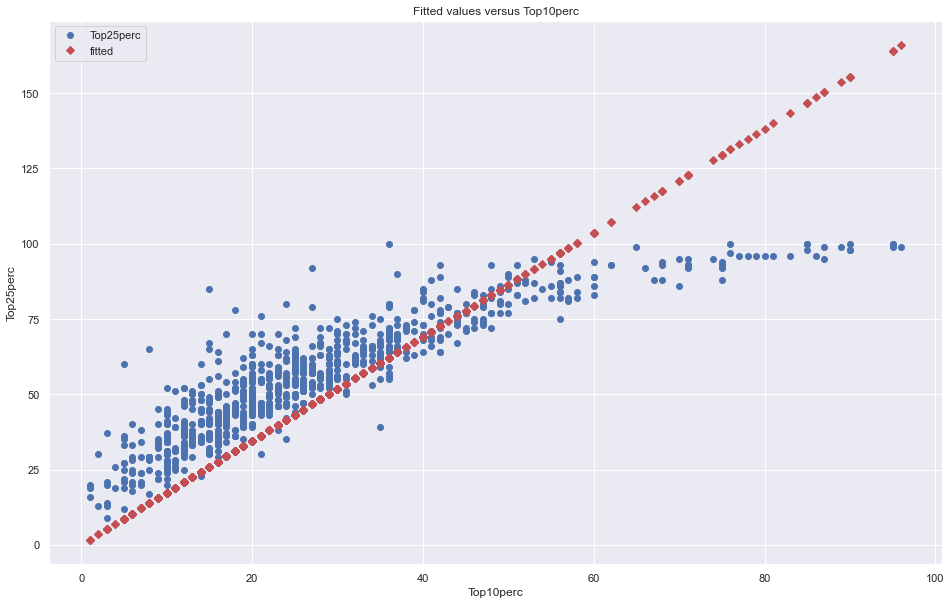

                                 OLS Regression Results                                
Dep. Variable:              Top25perc   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.911
Method:                 Least Squares   F-statistic:                              3325.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):                   9.01e-283
Time:                        17:04:46   Log-Likelihood:                         -3332.4
No. Observations:                 777   AIC:                                      6667.
Df Residuals:                     776   BIC:                                      6671.
Df Model:                           1                                                  
Covariance Type:                  HC2                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [6]:
# NO CONSTANT

x = college['Top10perc']
y = college['Top25perc']

model = sm.OLS(y,x)
results = model.fit(cov_type='HC2')
fig, ax = plt.subplots(figsize = (16, 10))
fig = sm.graphics.plot_fit(results, 'Top10perc', ax=ax, vlines=False)
plt.show()
print(results.summary())

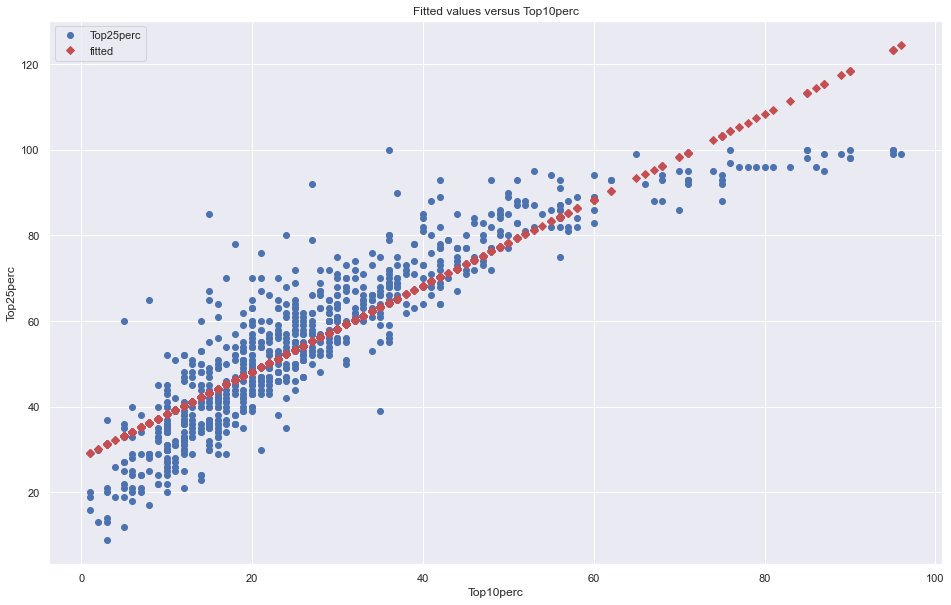

                            OLS Regression Results                            
Dep. Variable:              Top25perc   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     1557.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):          1.42e-187
Time:                        17:04:47   Log-Likelihood:                -2805.2
No. Observations:                 777   AIC:                             5614.
Df Residuals:                     775   BIC:                             5624.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.1984      0.746     37.785      0.0

In [7]:
# WITH CONSTANT

x = college['Top10perc']
y = college['Top25perc']

model = sm.OLS(y,sm.add_constant(x))
results = model.fit(cov_type='HC2')
fig, ax = plt.subplots(figsize = (16, 10))
fig = sm.graphics.plot_fit(results, 'Top10perc', ax=ax, vlines=False)
plt.show()
print(results.summary())

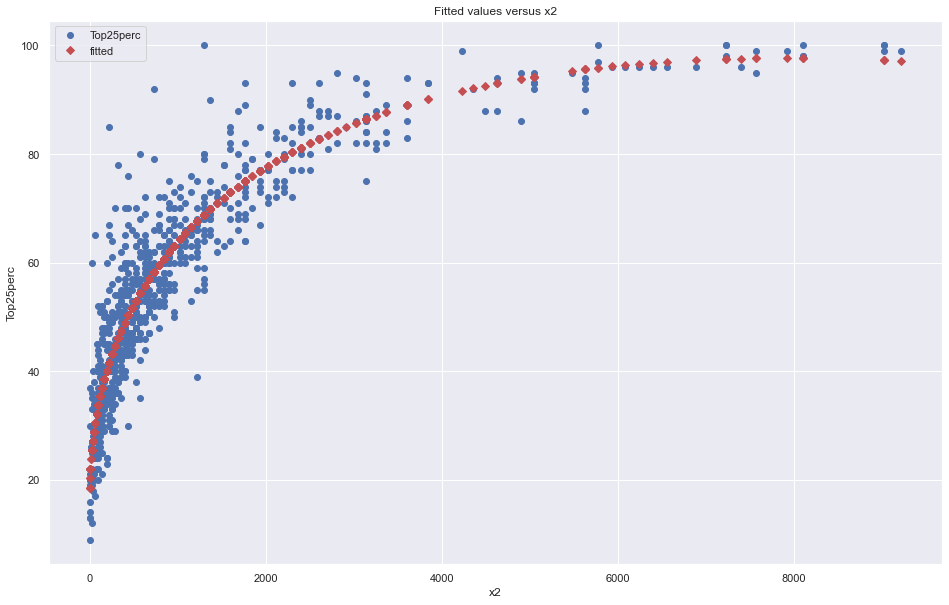

                            OLS Regression Results                            
Dep. Variable:              Top25perc   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     4716.
Date:                Wed, 20 Jan 2021   Prob (F-statistic):               0.00
Time:                        17:04:47   Log-Likelihood:                -2681.0
No. Observations:                 777   AIC:                             5368.
Df Residuals:                     774   BIC:                             5382.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.6786      0.880     18.963      0.0

In [8]:
# WITH CONSTANT

x = college['Top10perc']
y = college['Top25perc']

x = sm.add_constant(x)
x = np.concatenate([x,np.square(x.iloc[:,1])[:, np.newaxis]],axis=1)

model = sm.OLS(y,x)
results = model.fit(cov_type='HC2')
fig, ax = plt.subplots(figsize = (16, 10))
fig = sm.graphics.plot_fit(results, 'x2', ax=ax, vlines=False)
plt.show()
print(results.summary())

In [9]:
# Study using sns.regplot

# fig, ax = plt.subplots(4,1,figsize = (16, 16))
# plt.subplots_adjust(hspace=0.4, wspace=0.4)

# x = college['Top10perc']
# y = college['Top25perc']

# sns.regplot(data=college, x = x, y = y, ax = ax[0])
# sns.regplot(data=college, x = x, y = y, ax = ax[1], order=2)
# sns.regplot(data=college, x = (sm.add_constant(x)).iloc[:,1], y = y, ax = ax[2])
# sns.regplot(data=college, x = (sm.add_constant(x)).iloc[:,1], y = y, ax = ax[3], order=2)

# ax[0].set_title("One Variable")
# ax[1].set_title("One Variable and polynomial of degree 2")
# ax[2].set_title("One Variable with constant")
# ax[3].set_title("One Variable with constant and polynomial of degree 2")

# # NO CONSTANT

# est = sm.OLS(y,x).fit(cov_type='HC2')
# print(est.summary())

# # WITH CONSTANT

# est2 = sm.OLS(y,sm.add_constant(x)).fit(cov_type='HC2')
# print(est2.summary())

# # POLYNOMIAL DEGREE 2

# est1 = sm.OLS(y,sm.add_constant(x)).fit(cov_type='HC2')
# print(est1.summary())

2. Do private schools see more admissions overall? T-test this using a linear regression. Hint: use a binary explanatory variable for Private. Explain your model specification choices.

In [10]:
college.head()
college['Private'] = pd.get_dummies(college['Private'],drop_first=True)
x = college['Private']
y = college['Accept']

model = sm.OLS(y,sm.add_constant(x))
results = model.fit(cov_type='HC2')
# fig, ax = plt.subplots(figsize = (16, 10))
# fig = sm.graphics.plot_fit(results, 'Private', ax=ax, vlines=False)
# plt.show()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Accept   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     113.2
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           9.15e-25
Time:                        17:04:47   Log-Likelihood:                -7066.5
No. Observations:                 777   AIC:                         1.414e+04
Df Residuals:                     775   BIC:                         1.415e+04
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3919.2877    238.820     16.411      0.0

# 3. Auto prediction

Using the `auto.csv` dataset, perform a simple linear regression with `mpg` as the response variable and horsepower as the predictor. Answer the following:

 i. Is there a relationship between the predictor and the response?
 
 ii. How strong is the relationship between the predictor and the response?
 
 iii. Is the relationship between the predictor and the response positive or negative?

 iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?

 v. Make a regression plot the response and the predictor.

In [11]:
auto = pd.read_csv('data/auto.csv',delim_whitespace=True)
auto.dropna(inplace=True)
# print(auto.info())
auto = auto[auto['horsepower']!='?']
auto['horsepower'] = auto['horsepower'].astype(np.float64)
auto['mpg'] = auto['mpg'].astype(np.float64)
print(auto.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 1 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    float64
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   year          392 non-null    float64
 7   origin        392 non-null    float64
 8   name          392 non-null    object 
dtypes: float64(8), object(1)
memory usage: 30.6+ KB
None


In [12]:
x = auto['horsepower']
y = auto['mpg']

auto_pair = auto.loc[:,['mpg','horsepower']]
auto_pair.corr()

,mpg,horsepower
mpg,1.000000,-0.778427
horsepower,-0.778427,1.000000


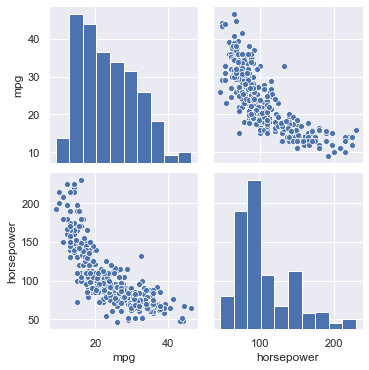

In [13]:
sns.pairplot(auto_pair)

In [14]:
x = sm.add_constant(x)
x = np.concatenate([x,((x.iloc[:,1])**3)[:, np.newaxis]],axis=1)

model = sm.OLS(y,x)
results = model.fit(cov_type='HC2')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     552.4
Date:                Wed, 20 Jan 2021   Prob (F-statistic):          2.24e-114
Time:                        17:04:48   Log-Likelihood:                -1135.2
No. Observations:                 392   AIC:                             2276.
Df Residuals:                     389   BIC:                             2288.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.0895      1.454     35.133      0.0

In [15]:
mpg_pred = results.predict([1,98,98**3])
print(mpg_pred)

[23.27999471]


**i. Is there a relationship between the predictor and the response?**
    
    Yes, there is a inverse relationship between mpg and horsepower.
   
    As horsepower increases , mpg diminishes.
   
**ii. How strong is the relationship between the predictor and the response?**

    There is a strong negative relationship, with a p-value of 0.

**iii. Is the relationship between the predictor and the response positive or negative?**
    
    The relationship is negative, as indicated by the correlation coefficient of -0.761004 and linear regression coefficient of -0.3128.
    
    The linear regression coefficient represents a negative slope.

**iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95 % confidence and prediction intervals ?**
    
    The predicted mpg for a horsepower of 98 is 23.53865482.

**v. Make a regression plot the response and the predictor**

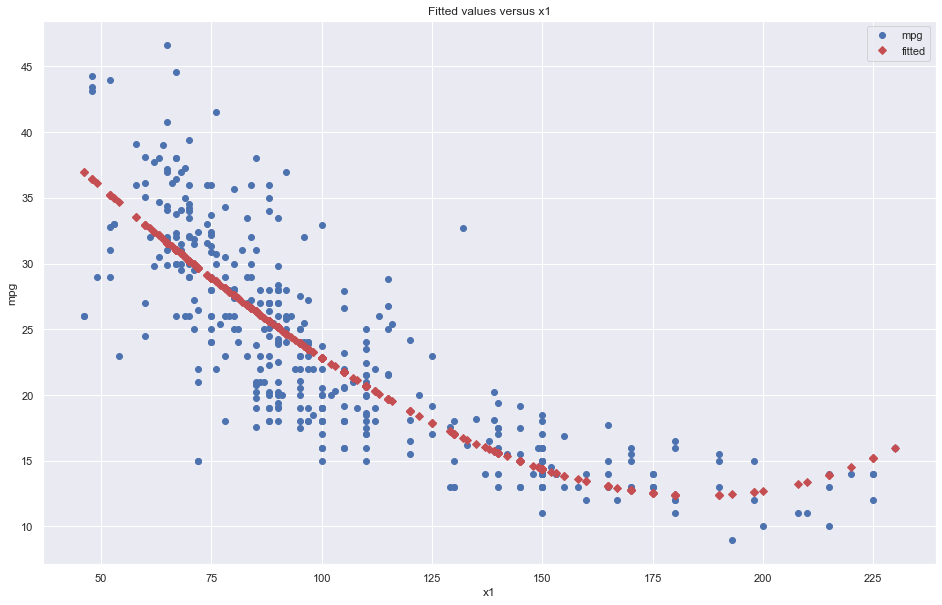

In [16]:
fig, ax = plt.subplots(figsize = (16, 10))
fig = sm.graphics.plot_fit(results, 1, ax=ax, vlines=False)
plt.show()

# 4. Auto Multiple Regression

Perform a multiple linear regression with `mpg` as the response and all other variables except name in `auto` as the predictors. Comment on the output:

i. Is there a relationship between the predictors and the response?

ii. Which predictors appear to have a statistically significant relationship to the response?

iii. What does the coefficient for the year variable suggest?

iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?

v. Is there heteroscedasticity in the fit?

In [17]:
auto = pd.read_csv('data/auto.csv',delim_whitespace=True)
auto.dropna(inplace=True)
# print(auto.info())
auto = auto[auto['horsepower']!='?']
auto['horsepower'] = auto['horsepower'].astype(np.float64)
auto['mpg'] = auto['mpg'].astype(np.float64)
print(auto.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 1 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    float64
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   year          392 non-null    float64
 7   origin        392 non-null    float64
 8   name          392 non-null    object 
dtypes: float64(8), object(1)
memory usage: 30.6+ KB
None


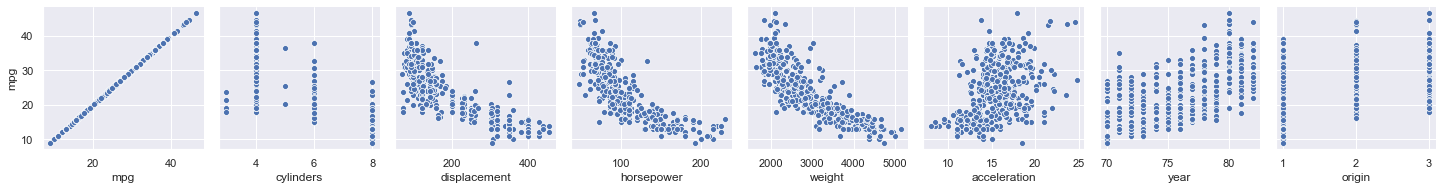

In [18]:
auto_all = auto.drop(['name'], axis=1)
x = auto_all.drop(['mpg'], axis=1)
y = auto['mpg']

sns.pairplot(data=auto_all, y_vars=['mpg'], x_vars=auto_all.columns)

In [19]:
auto_all.corr()[['mpg']].sort_values(['mpg'])

,mpg
weight,-0.832244
displacement,-0.805127
horsepower,-0.778427
cylinders,-0.777618
acceleration,0.423329
origin,0.565209
year,0.580541
mpg,1.000000


In [20]:
x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit(cov_type='HC2')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.5
Date:                Wed, 20 Jan 2021   Prob (F-statistic):          1.98e-139
Time:                        17:04:50   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:                  HC2                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.697     -3.666   

**i. Is there a relationship between the predictors and the response?**

    Yes, based on the correlation matrix, there is a relationship between all predictors and the response, mpg.

**ii. Which predictors appear to have a statistically significant relationship to the response?**

    Predictors displacement, weight, year and origin have a statistically significant relationship to mpg given low p-values.
    Cylinders, horsepower and cceleration are statistically insignificant with an elevated p-values of greater than 0.1.
    
**iii. What does the coefficient for the year variable suggest?**
    
    The coefficient of 0.7508 indicates a near linear relationship between year and mpg. As the year increases, the mpg range shifts up.
    More recent autos have greater mpg.

**iv. Comment on any problems you see with the fit. Do the residual plots suggest any unusually large outliers?**
    
    Yes, residual plots indicate some structure to the residuals and thereby indicates that the fit is problematic
    
    ref: https://seaborn.pydata.org/tutorial/regression.html
    ref: https://seaborn.pydata.org/generated/seaborn.residplot.html

**v. Is there heteroscedasticity in the fit?**

    Based on the fitted residual plots, there is some heteroscedasticity in the fit.

C:\Users\gayar\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:165: RuntimeWarning: invalid value encountered in greater_equal
  res = _lowess(y, x, frac=frac, it=it, delta=delta)


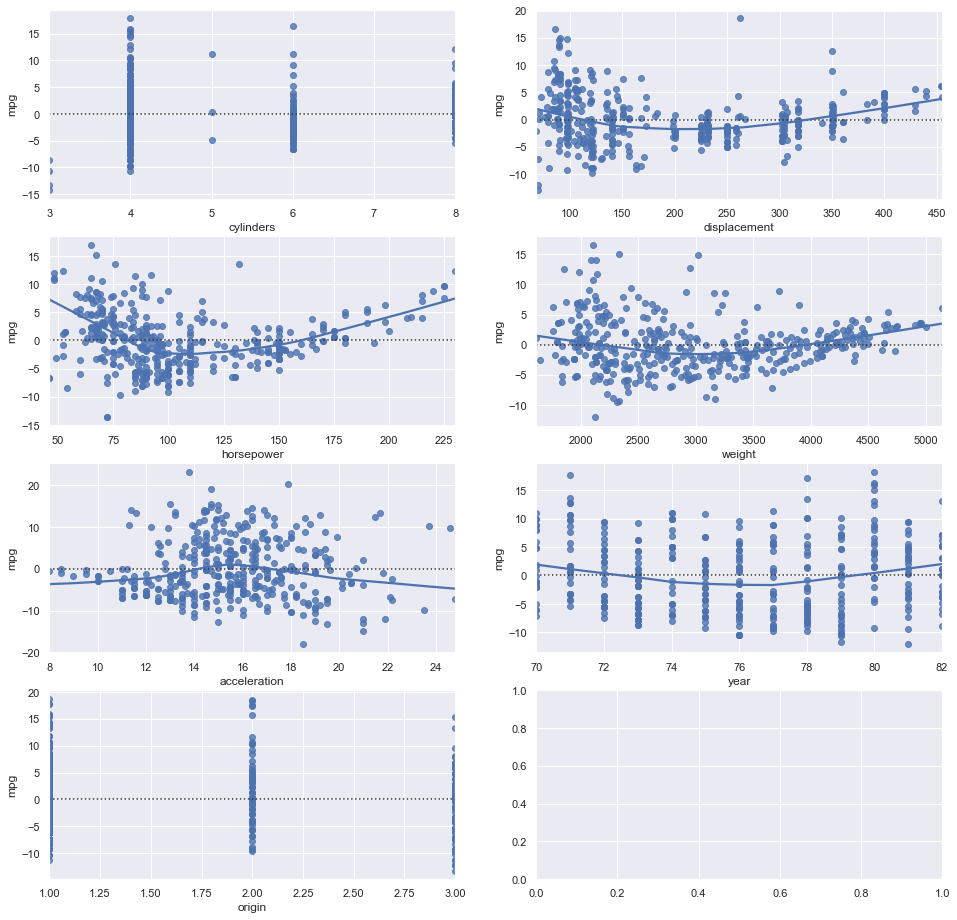

In [21]:
fig, ax = plt.subplots(4,2,figsize = (16, 16))
sns.residplot(data=results, x=x['cylinders'], y=y, lowess=True,ax=ax[0,0])
sns.residplot(data=results, x=x['displacement'], y=y, lowess=True, ax=ax[0,1])
sns.residplot(data=results, x=x['horsepower'], y=y, lowess=True, ax=ax[1,0])
sns.residplot(data=results, x=x['weight'], y=y, lowess=True, ax=ax[1,1])
sns.residplot(data=results, x=x['acceleration'], y=y, lowess=True, ax=ax[2,0])
sns.residplot(data=results, x=x['year'], y=y, lowess=True, ax=ax[2,1])
sns.residplot(data=results, x=x['origin'], y=y, lowess=True, ax=ax[3,0])

In [22]:
# ref : https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/ 

# 5. Car Seats

This question should be answered using the Carseats data set

1. Fit a multiple regression model to predict Sales using Price, Urban, and US.

2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?

4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.

6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).

**1. Fit a multiple regression model to predict Sales using Price, Urban, and US.**

In [23]:
carseats = pd.read_csv('data/carseats.csv')

carseats['Urban'] = pd.get_dummies(carseats['Urban'],drop_first=True)
carseats['US'] = pd.get_dummies(carseats['US'],drop_first=True)

cs = carseats[['Sales','Price','Urban','US']]
x = cs.drop(['Sales'], axis=1)
y = carseats['Sales']

x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit(cov_type='HC2')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     43.09
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           4.04e-24
Time:                        17:04:53   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1863.
Df Residuals:                     396   BIC:                             1879.
Df Model:                           3                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0435      0.641     20.333      0.0

In [24]:
cs.corr()

,Sales,Price,Urban,US
Sales,1.000000,-0.444951,-0.015419,0.177093
Price,-0.444951,1.000000,0.047016,0.057861
Urban,-0.015419,0.047016,1.000000,0.047085
US,0.177093,0.057861,0.047085,1.000000


**2. Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!**
    
    Price : there is a negative relationship between Price and Sales, where as the Price increases, Sales decrease. This relationship is statistically significant as it has a p-value of 0
    Urban : there is a negative relationship between Urban and Sales. However, this relationship is not statistically significant as it has a p-value greater than 0.1
    US : there is a positive and appreciating relationship between US and Sales. US is a qualitative variable, where if US is true, than the Sales appreciate with a rate of 1.2006

**3. For which of the predictors can you reject the null hypothesis H0 : βj = 0?**

    We can reject null hypothesis for Price and US, as the p-values for these variables is 0.000.

**4. On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.**




In [25]:
cs = carseats[['Sales','Price','US']]
x = cs.drop(['Sales'], axis=1)
y = carseats['Sales']

x = sm.add_constant(x)

model = sm.OLS(y,x)
results = model.fit(cov_type='HC2')
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     64.66
Date:                Wed, 20 Jan 2021   Prob (F-statistic):           4.90e-25
Time:                        17:04:53   Log-Likelihood:                -927.66
No. Observations:                 400   AIC:                             1861.
Df Residuals:                     397   BIC:                             1873.
Df Model:                           2                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0308      0.622     20.944      0.0


**5. How well do the models in 1 and 4 fit the data? Explain which statistics show the difference.**

    Both models fit the data very similarily with the smaller fitting the data marginally better.
    This can be see in a  lower F-statistic p-value (4.90e-25 vs 4.04e-24 of first model) and marginally lower AIC and BIC values.

**6. Using the model from (e), obtain 95 % confidence intervals for the coefficient(s).**

In [26]:
conf_int = results.conf_int(alpha=0.05)
conf_int.iloc[1:]

,0,1
Price,-0.064605,-0.04435
US,0.716136,1.68315
